####

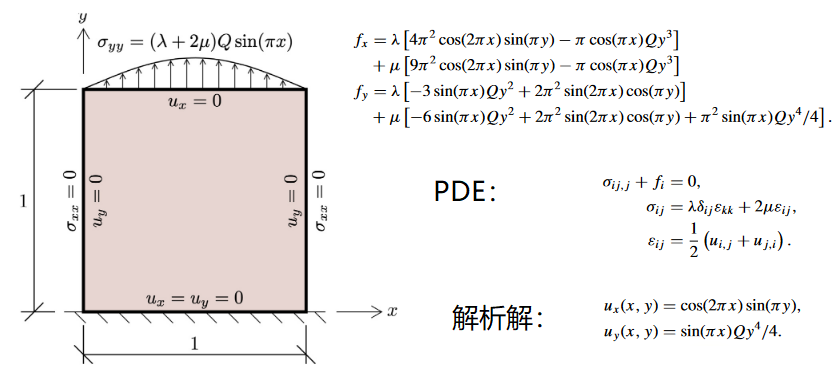

In [31]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

pi = np.pi
# Lame paramters used in the paper.
lame1 = 1.0
lame2 = 0.5
qload = 4.0

from IPython.display import Image
Image('data/solid/scheme.jpg')

#### 2d-solid 正向问题
求解 $u(x,y)$, $v(x,y)$
$$
     \frac{\partial^2 u}{\partial x^2} + \frac{1-\nu}{2} \frac{\partial^2 u}{\partial y^2} + \frac{1-\nu}{2} \frac{\partial^2 v}{\partial y\partial x} + \nu\frac{\partial^2 v}{\partial y\partial x} + \frac{1-\mu^2}{E}f_x = 0 \\
     \frac{\partial^2 u}{\partial y^2} + \frac{1-\nu}{2} \frac{\partial^2 v}{\partial x^2} + \frac{1-\nu}{2} \frac{\partial^2 u}{\partial y\partial x} + \nu\frac{\partial^2 u}{\partial y\partial x} + \frac{1-\mu^2}{E}f_y = 0 \\
    u(x, 0) = 0, v(x, 0) = 0, u(x, 1)=0, \sigma_{yy}=(\lambda+2\mu)Qsin(\pi x)\\
    \lambda = 1.0, \mu = 0.5
$$
其解析解为： $u(x, y)=cos(2\pi x)sin(\pi y), v(x, y)=sin(\pi x)Qy^4/4$

In [32]:

class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.GELU())

        self.lame1 = nn.Parameter(torch.rand((1,)))
        self.lame2 = nn.Parameter(torch.rand((1,)))

    def caculate(self, inn_var, out_var, is_inverse):
        Ux = out_var[..., (0,)]
        Uy = out_var[..., (1,)]

        Exx = gradients(Ux, inn_var)[..., (0,)]
        Eyy = gradients(Uy, inn_var)[..., (1,)]
        Exy = (gradients(Ux, inn_var)[..., (1,)] + gradients(Uy, inn_var)[..., (0,)]) * 0.5

        if is_inverse:
            Sxx = Exx * (2 * self.lame2 + self.lame1) + Eyy * self.lame1
            Syy = Eyy * (2 * self.lame2 + self.lame1) + Exx * self.lame1
            Sxy = Exy * 2 * self.lame2
        else:
            Sxx = Exx * (2 * lame2 + lame1) + Eyy * lame1
            Syy = Eyy * (2 * lame2 + lame1) + Exx * lame1
            Sxy = Exy * 2 * lame2

        fields = torch.cat((Ux, Uy, Exx, Eyy, Exy, Sxx, Syy, Sxy), dim=-1)
        return fields

    def equation(self, inn_var, fields, force):

        eqs1 = gradients(fields[..., (-3,)], inn_var)[..., (0,)] + gradients(fields[..., (-1,)], inn_var)[..., (1,)] - force[..., (0,)]
        eqs2 = gradients(fields[..., (-1,)], inn_var)[..., (0,)] + gradients(fields[..., (-2,)], inn_var)[..., (1,)] - force[..., (1,)]

        res = torch.cat((eqs1, eqs2), dim=-1)

        return res

#### 数据生成

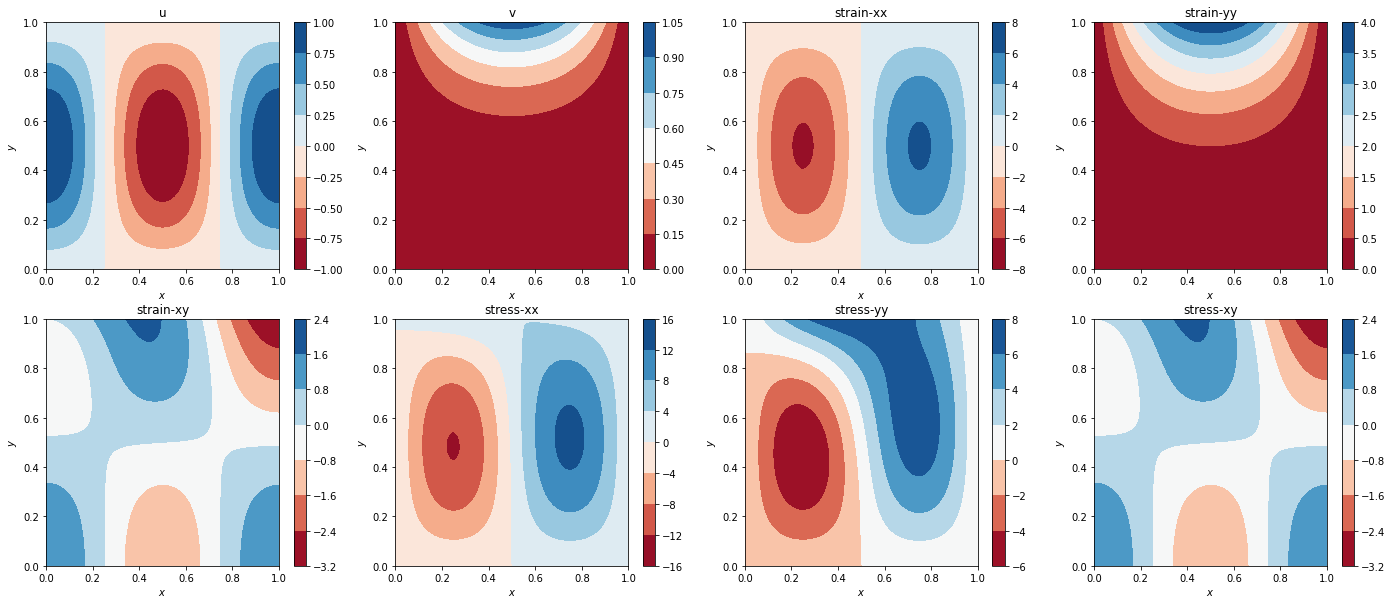

In [33]:
Nx = 100
Ny = 100  # change to 100
node_x = np.linspace(0.0, 1.0, Nx)[:, None]
node_y = np.linspace(0.0, 1.0, Ny)[:, None]
node_x = np.tile(node_x, (1, node_y.shape[0]))  # Nx x Ny
node_y = np.tile(node_y, (1, node_x.shape[0])).T  # Nx x Ny

def load(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    return Q * np.sin(pi * x)

def bodyfx(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    frc = - lame1 * (4 * pi ** 2 * np.cos(2 * pi * x) * np.sin(pi * y) - Q * y ** 3 * pi * np.cos(pi * x)) \
          - lame2 * (pi ** 2 * np.cos(2 * pi * x) * np.sin(pi * y) - Q * y ** 3 * pi * np.cos(pi * x)) \
          - 8 * lame2 * pi ** 2 * np.cos(2 * pi * x) * np.sin(pi * y)
    return frc

def bodyfy(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    frc = lame1 * (3 * Q * y ** 2 * np.sin(pi * x) - 2 * pi ** 2 * np.cos(pi * y) * np.sin(2 * pi * x)) \
          - lame2 * (2 * pi ** 2 * np.cos(pi * y) * np.sin(2 * pi * x) + (Q * y ** 4 * pi ** 2 * np.sin(pi * x)) / 4) \
          + 6 * Q * lame2 * y ** 2 * np.sin(pi * x)
    return frc

def dispx(xx):
    x, y = xx[..., 0], xx[..., 1]
    return np.cos(2 * pi * x) * np.sin(pi * y)

def dispy(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    return np.sin(pi * x) * Q * y ** 4 / 4

def strainxx(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    return -2 * pi * np.sin(2 * pi * x) * np.sin(pi * y)

def strainyy(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    return np.sin(pi * x) * Q * y ** 3

def strainxy(xx):
    x, y = xx[..., 0], xx[..., 1]
    Q = qload
    return 0.5 * (pi * np.cos(2 * pi * x) * np.cos(pi * y) + pi * np.cos(pi * x) * Q * y ** 4 / 4)

def stressxx(xx):
    return (lame1 + 2 * lame2) * strainxx(xx) + lame1 * strainyy(xx)

def stressyy(xx):
    return (lame1 + 2 * lame2) * strainyy(xx) + lame1 * strainxx(xx)

def stressxy(xx):
    return 2.0 * lame2 * strainxy(xx)

input = np.stack((node_x, node_y), axis=-1)
field = np.stack((dispx(input), dispy(input), strainxx(input), strainyy(input), strainxy(input), stressxx(input), stressyy(input), stressxy(input),), axis=-1)
force = np.stack((bodyfx(input), bodyfy(input)), axis=-1)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nodes_train = torch.tensor(input, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)
force_train = torch.tensor(force, dtype=torch.float32).to(device)

field_name=( 'u', 'v',  'strain-xx', 'strain-yy', 'strain-xy', 'stress-xx', 'stress-yy', 'stress-xy')
plt.figure(figsize=(24, 10))
plt.clf()
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.contourf(node_x, node_y, field[..., i], cmap='RdBu')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(field_name[i])

#### 定义训练过程

In [34]:
# 建立网络
Net_model = Net(planes=[2] + [32] * 3 + [2], ).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.002, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[70000, 90000, 100000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/', input_name=('x', 'y'), field_name=( 'u', 'v', 'strain-xx', 'strain-yy', 'strain-xy', 'stress-xx', 'stress-yy', 'stress-xy'), )
def train(inn_var, force, out_true, model, Loss, optimizer, scheduler, log_loss, is_inverse):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        fields_pred = model.caculate(inn_var, out_var, is_inverse=is_inverse)
        res_i = model.equation(inn_var, fields_pred, force)


        if is_inverse:
            bcs_loss_l11 = Loss(fields_pred[0, :, (1, -3,)], out_true[0, :, (1, -3,)])
            bcs_loss_l21 = Loss(fields_pred[-1, :, (1, -3,)], out_true[-1, :, (1, -3,)])
            bcs_loss_l12 = Loss(fields_pred[:, 0, (0, 1)], out_true[:, 0, (0, 1)])
            bcs_loss_l22 = Loss(fields_pred[:, -1, (0, -2)], out_true[:, -1, (0, -2)])
            bcs_loss = bcs_loss_l11 + bcs_loss_l21 + bcs_loss_l12 + bcs_loss_l22

        else:
            bcs_loss_l12 = Loss(fields_pred[:, 0, (0, 1)], out_true[:, 0, (0, 1)])
            bcs_loss_l22 = Loss(fields_pred[:, -1, (0, -2)], out_true[:, -1, (0, -2)])
            bcs_loss = bcs_loss_l12 + bcs_loss_l22
        eqs_loss = Loss(res_i, torch.zeros_like(res_i, dtype=torch.float32))
        loss_batch = bcs_loss + eqs_loss
        loss_batch.backward()

        data_loss = Loss(fields_pred, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model, force, is_inverse):

    out_var = model(inn_var)
    fields_pred = model.caculate(inn_var, out_var, is_inverse)
    equation = model.equation(inn_var, fields_pred, force)
    return fields_pred, equation

#### 执行训练过程

In [36]:
star_time = time.time()
log_loss = []
pbar = trange(100000)

inn_var = nodes_train
inn_var.requires_grad_(True)

# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, force_train, field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss, is_inverse=False)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], })

  2%|▏         | 1681/100000 [01:39<1:36:45, 16.94it/s, lr=0.002, dat_loss=0.903, cost:=99.2, eqs_loss=0.219, bcs_loss=0.0224]


KeyboardInterrupt: 

#### 残差损失可视化

Text(0.5, 1.0, 'training loss')

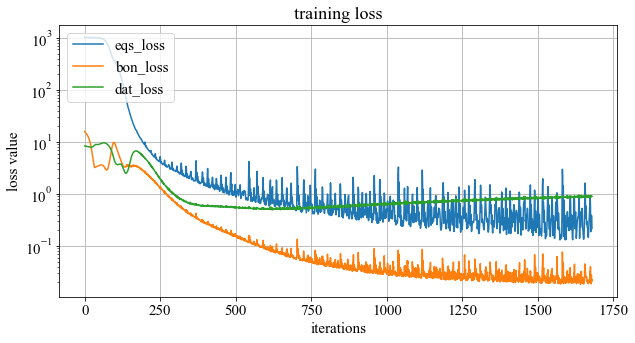

In [41]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bon_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 结果对比

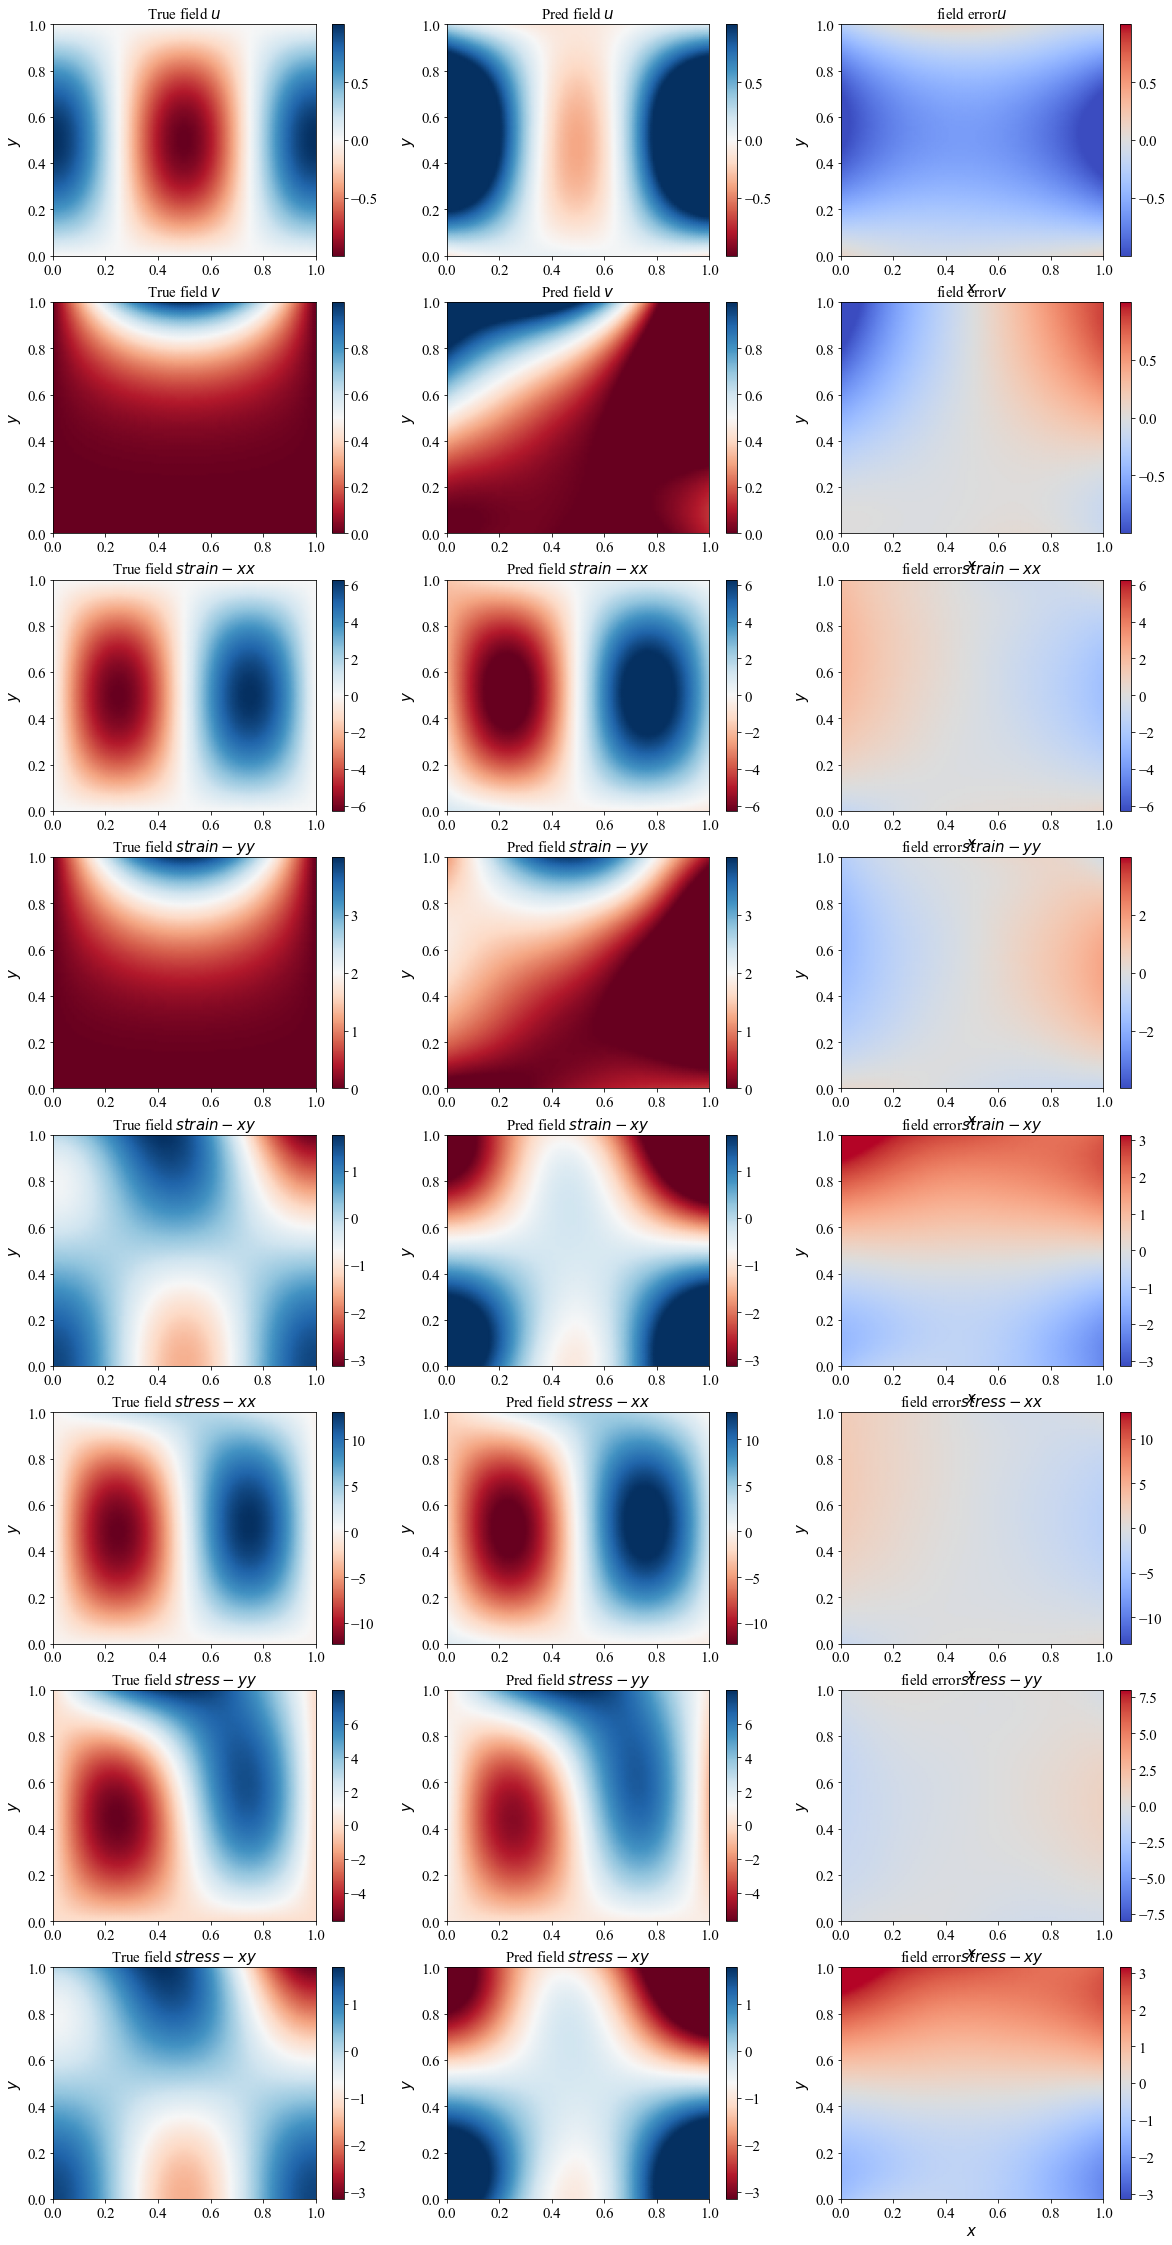

In [40]:
field_pred, equation = inference(inn_var, Net_model, force_train, is_inverse=False)

input_visual = input
field_visual_t = field
field_visual_p = field_pred.detach().cpu().numpy()

fig = plt.figure(figsize=(20, 40))
Visual.plot_fields_ms(field_visual_t, field_visual_p, input_visual)